# ECG Arrhythmia Detection Using Discrete Wavelet Transform

In this notebook stands the foundation of the whole ECG analysis and arrhythmia detection, using the discrete wavelet transform (DWT) and the MIT-BIH Arrhythmia Database in order to detect anomalies based on data. 

## 0. Setup

In this section, we import all libraries needed before proceeding. 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
import wfdb

## 1. Data Loading and Preprocessing

- `load_mit_bih_db`: this function loads the dataset and saves the ECG signal, sampling frequency, and any available annotations. 
- `preprocess`: this function works the ECG original signal based on the samplig frequency for baseline wander removal and normalization of the signal. For the Butterworth filter, it was chosen to be represented in sos format (second-order sections) to increase stability asa this is a high-order filter. 

In [11]:
def load_mit_bih_db(record_name = '100', duration = 10): 
    """
    ecg_signal: ndarray 
        ECG signal MLII lead.
    fs: int 
        sampling frequency. 
    ann_dict : dict 
        annotation data from each ecg. 
    """
    # mit-bih is sampled at 360 Hz, we're looking at 10 * 360 = 3600 samples of data
    record = wfdb.rdrecord(record_name, pn_dir='mitdb', sampto=duration*360)
    annotation = wfdb.rdann(record_name, 'atr', pn_dir='mitdb', sampto=duration*360)
    
    # signal MLII extraction that exists on the first channel. 
    ecg_signal = record.p_signal[:, 0]
    fs = record.fs
    
    # annotations from each ecg 
    ann_dict = {
        'sample': annotation.sample,
        'symbol': annotation.symbol,  # N=normal
    }
    
    return ecg_signal, fs, ann_dict

def preprocess(ecg_signal, fs): 
    """ 
    processed_signal: ndarray 
        preprocessed ECG signal (baseline wander removal and normalization)
    """
    
    # we remove the baseline wander with the High-Pass Filter, using a 0.5 Hz cutoff
    sos = signal.butter(4, 0.5, btype = 'high' , fs=fs, output='sos')
    filtered = signal.sosfilt(sos, ecg_signal)
    # normalization 
    processed_signal = (filtered - np.mean(filtered))/np.std(filtered) 
    
    return processed_signal


## 2. DWT Decomposition and Analysis 

- `dwt`: using the wavelet Daubechies 4 as it's most commonly used in practice and experimentation for these type of projects. The use of a level 5 decomposition comes from knowing that the frequency is 360 Hz. Each level splits the frequency band in a way that results easier to see and recognize the necessary frequency for the QRS complex, which is our main focus. This complex has most energy around 5-40 Hz, which makes coefficients cD3 and cD4 the best for R-peak detection. 
- `reconstruct`: this functions uses the coefficientes obtained through the wavelet decomposition function in order to reconstruct it. 
- `calc_entropy`: calculation of Shannon Entropy based on the wavelet's coefficients. This functino is used on `dwt_feats`.
- `dwt_feats`: returns the dictionary `features` that contains information regarding the distinct coefficients obtained during function `dwt`.

In [12]:
def dwt(ecg_signal, wavelet = 'db4', level = 5): 
    """ 
    coeffs: list 
        wavelet coefficients [cA5, cD5, cD4, cD3, cD2, cD1] <- total 6 elements 
    """
    # wavelet decomposition function from pywt
    coeffs = pywt.wavedec(ecg_signal, wavelet, level = level)
    return coeffs 

def reconstruct(coeffs, wavelet='db4'): 
    """ 
    recons: ndarray 
        reconstructed signal based on coefficients
    """
    # wavelet recomposition function from pywt 
    recons = pywt.waverec(coeffs, wavelet) 

def calc_entropy(coeffs): 
    # calculation of Shannon entropy of wavelet coefficients

    energy = coeffs**2
    total_energy = np.sum(energy) 

    if (total_energy == 0):
        return 0
    prob_dist = energy/total_energy

    prob_dist = prob_dist[prob_dist > 0]
    entropy = -np.sum(prob_dist * np.log2(prob_dist))
    return entropy 

def dwt_feats(coeffs): 
    """ 
    features: dict 
        includes the following features of the DWT: 
        - cA Energy
        - cA Mean 
        - cA Standard Dev. 
        - cA Entropy
        - For every cD, includes energy, mean, standard dev., max coefficient value, and entropy in their detail level
    """
    features = {}

    # saving the approx. coefficients (low freq)
    features['cA_energy'] = np.sum(coeffs[0]**2)
    features['cA_mean'] = np.mean(np.abs(coeffs[0]))
    features['cA_std'] = np.std(coeffs[0])
    features['cA_entropy'] = calc_entropy(coeffs[0])

    # saving the detail coefficients (high freq) 
    for i, d in enumerate(coeffs[1:],1): 
        features[f'cD{len(coeffs)-i}_energy'] = np.sum(d**2)
        features[f'cD{len(coeffs)-i}_mean'] = np.mean(np.abs(d))
        features[f'cD{len(coeffs)-i}_std'] = np.std(d)
        features[f'cD{len(coeffs)-i}_max'] = np.max(np.abs(d))
        features[f'cD{len(coeffs)-i}_entropy'] = calc_entropy(d)
    
    # final total energy 
    features['total_energy'] = sum(np.sum(c**2) for c in coeffs)
    return features 


## 3. Beat Segmentation and Feature Comparison

- `segments`: this function divides the electrocardiogram in windows around the R peak, helping to catalogize each heartbeat as its own and identify it's behavior directly, instead of analyzing the ECG as a whole. 
- `extract_beat_fts`: similar to the function `dwt_feats`, this function extracts the coefficients and features of a specific beat. 
- `avg_fts`: this function analyzes all beat segments from the original ECG signal and returns the average features per each category of beat, using the average as a more representative value of comparison. 

In [13]:
def segments(ecg_signal, anns, fs, window_size = 0.3): 
    """ 
    beats: dict
        beat type as key and list of beat segments
    """

    half_window = int(window_size *fs/2) 
    beats = {}

    for sample, symbol in zip(anns['sample'], anns['symbol']): 
        start = max(0, sample - half_window) 
        end = min(len(ecg_signal), sample + half_window) 

        beat_seg = ecg_signal[start:end] 

        if(len(beat_seg) == 2*half_window): 
            if(symbol not in beats): 
                beats[symbol] = []
            beats[symbol].append(beat_seg) 
        
    return beats

def extract_beat_fts(beat_seg, wavelet = 'db4', level = 5): 
    coeffs = dwt(beat_seg, wavelet = wavelet, level = level) 
    feats = dwt_feats(coeffs) 
    return feats 

def avg_fts(beats, wavelet = 'db4', level = 5): 
    all_fts = []
    
    for beat in beats: 
        feat = extract_beat_fts(beat, wavelet = wavelet, level = level) 
        all_fts.append(feat)
    
    avg_feats = {}
    fts_names = all_fts[0].keys() 

    for name in fts_names: 
        values = [f[name] for f in all_fts]
        avg_feats[name] = np.mean(values) 

    return avg_feats 

## 4. Visualization 

- `plot_signal_ann`: function that plots the original ECG signal on a time vs normalized amplitude, and includes the corresponding annotations. 
- `plot_dwt_decomposition`: using the distinct coefficients, a graph of the distinct DWT levels are plotted. 
- `plot_feature_comparison`: plots a comparison between features, in case abnormal beats are detected in segments of the ECG. 

In [14]:
def plot_signal_ann(ecg_signal, fs, annotations, duration=5):
    """ 
    plots original signal with its respective annotations
    """
    # we create a time array for plotting. 
    time = np.arange(len(ecg_signal)) / fs
    plt.figure(figsize=(15, 4))
    plt.plot(time, ecg_signal, 'b-', linewidth=0.5, label='ECG Signal')
    
    # Plot annotations
    for sample, symbol in zip(annotations['sample'], annotations['symbol']):
        if sample < len(ecg_signal):
            plt.plot(time[sample], ecg_signal[sample], 'ro', markersize=6)
            plt.text(time[sample], ecg_signal[sample], f' {symbol}', fontsize=10)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (normalized)')
    plt.title('ECG Signal with Annotations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, duration)
    plt.tight_layout()
    plt.show()


def plot_dwt_decomposition(coeffs, fs, wavelet='db4'):
    """
    plots all levels of dwt decomposition
    """

    n_levels = len(coeffs) - 1
    fig, axes = plt.subplots(n_levels + 1, 1, figsize=(15, 2*n_levels))
    
    # plot approximation coefficients
    axes[0].plot(coeffs[0], 'g-', linewidth=0.8)
    axes[0].set_title(f'Approximation Coefficients (cA{n_levels})')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Plot detail coefficients
    for i, detail in enumerate(coeffs[1:], 1):
        axes[i].plot(detail, 'b-', linewidth=0.8)
        level = n_levels - i + 1
        
        # Calculate frequency range for this level
        freq_max = fs / (2 ** (i))
        freq_min = fs / (2 ** (i + 1))
        
        axes[i].set_title(f'Detail Coefficients (cD{level}) - Freq: {freq_min:.1f}-{freq_max:.1f} Hz')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Sample Index')
    plt.tight_layout()
    plt.show()

def plot_feature_comparison(normal_features, abnormal_features):
    feature_names = list(normal_features.keys())
    normal_values = list(normal_features.values())
    abnormal_values = list(abnormal_features.values())
    
    x = np.arange(len(feature_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 6))
    bars1 = ax.bar(x - width/2, normal_values, width, label='Normal', alpha=0.8)
    bars2 = ax.bar(x + width/2, abnormal_values, width, label='Abnormal', alpha=0.8)
    
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Value', fontsize=12)
    ax.set_title('DWT Feature Comparison: Normal vs Abnormal Beats')
    ax.set_xticks(x)
    ax.set_xticklabels(feature_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


## 5. Example Usage

This section divides in two parts: an analysis and recognition of the R-peaks in a 10 second segment of an ECG, and a comparison between location of R-peaks in the average normal heartbeat of the patient and any abnormalities that they may have. 

signal length: 3600 samples
sampling frequency: 360 Hz
number of annotations: 14
annotation types: {'A', 'N', '+'}


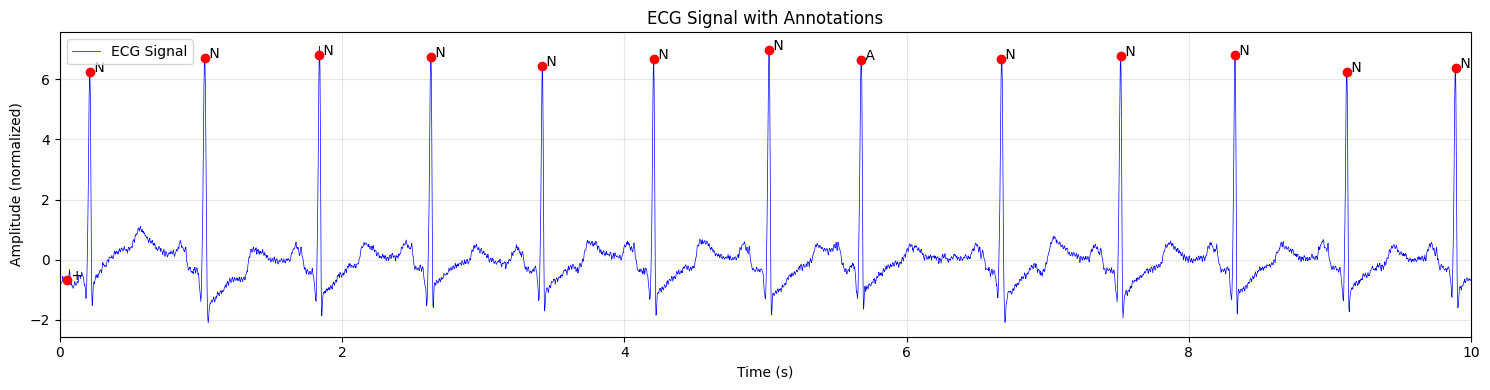


performing DWT decomposition
number of decomposition levels: 4
  cA4: 231 coefficients
  cD4: 231 coefficients
  cD3: 456 coefficients
  cD2: 905 coefficients
  cD1: 1803 coefficients


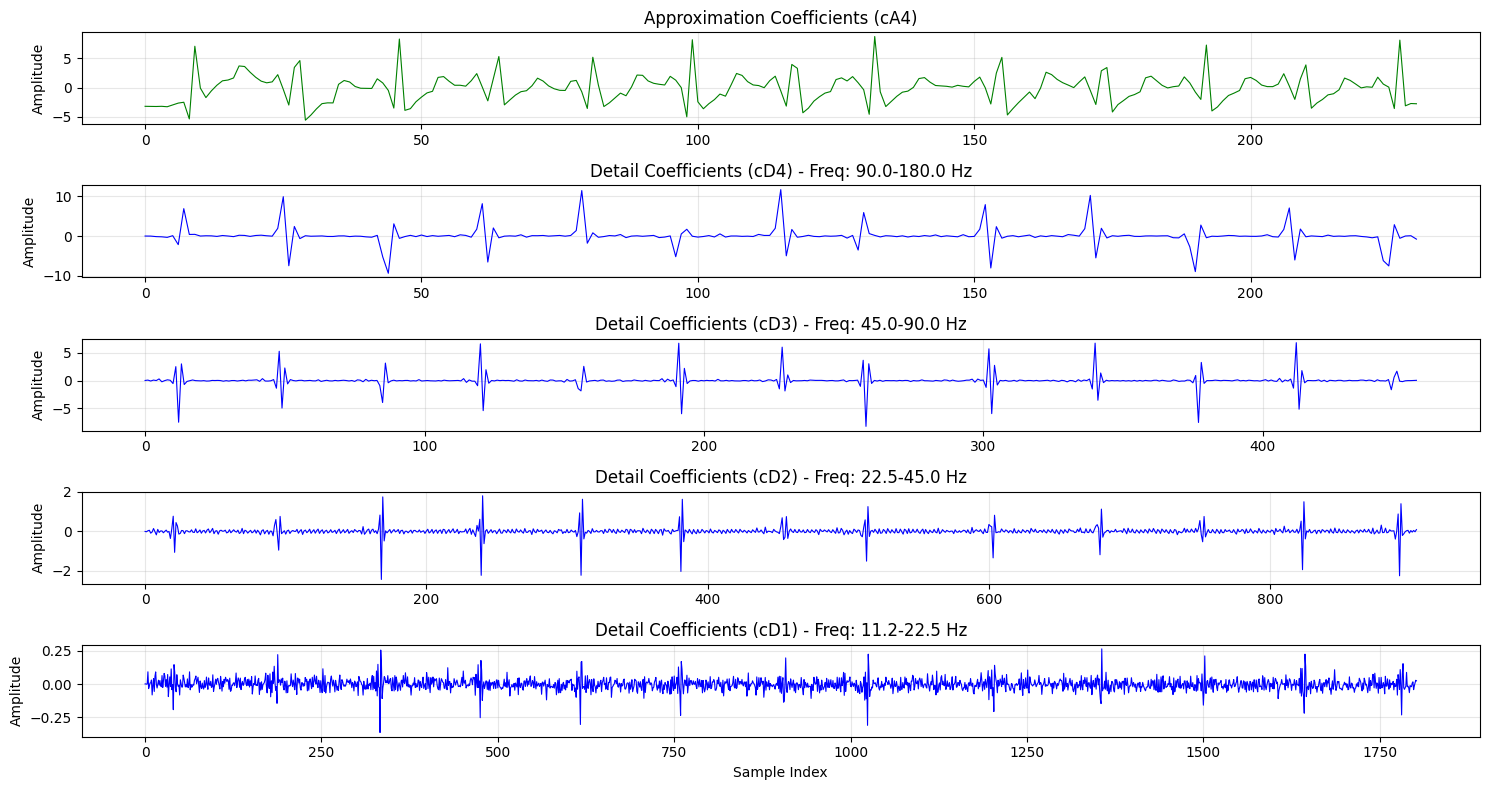


extracted DWT features:
  cA_energy: 1412.5695
  cA_mean: 1.8523
  cA_std: 2.4715
  cA_entropy: 6.4774
  cD4_energy: 1404.3058
  cD4_mean: 1.0192
  cD4_std: 2.4643
  cD4_max: 11.6365
  cD4_entropy: 4.6563
  cD3_energy: 767.7499
  cD3_mean: 0.4217
  cD3_std: 1.2975
  cD3_max: 8.2326
  cD3_entropy: 4.7820
  cD2_energy: 71.6123
  cD2_mean: 0.1188
  cD2_std: 0.2813
  cD2_max: 2.4346
  cD2_entropy: 5.5634
  cD1_energy: 3.9217
  cD1_mean: 0.0330
  cD1_std: 0.0465
  cD1_max: 0.3633
  cD1_entropy: 8.9051
  total_energy: 3660.1591


In [15]:
# example: loading and analyzing a record
ecg, fs, ann = load_mit_bih_db('100', duration=10)

print(f"signal length: {len(ecg)} samples")
print(f"sampling frequency: {fs} Hz")
print(f"number of annotations: {len(ann['sample'])}")
print(f"annotation types: {set(ann['symbol'])}")

# preprocess
ecg_processed = preprocess(ecg, fs)
# visualize
plot_signal_ann(ecg_processed, fs, ann, duration=10)
lvl = 4
# perform the dwt
print("\nperforming DWT decomposition")
coeffs = dwt(ecg_processed, wavelet='db4', level=lvl)

print(f"number of decomposition levels: {len(coeffs)-1}")
for i, c in enumerate(coeffs):
    if(i == 0):
        print(f"  cA{len(coeffs)-1}: {len(c)} coefficients")
    else:
        print(f"  cD{len(coeffs)-i}: {len(c)} coefficients")

# visualize decomposition
plot_dwt_decomposition(coeffs, fs, wavelet='db4')

# extract features from a segment
features = dwt_feats(coeffs)
print("\nextracted DWT features:")
for name, value in features.items():
    print(f"  {name}: {value:.4f}")


beat types found: ['N', 'A']
N: 11
A: 1

abnormal features were identified (type 'A'). extracting features...


C:\Users\Laurie Hernández\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


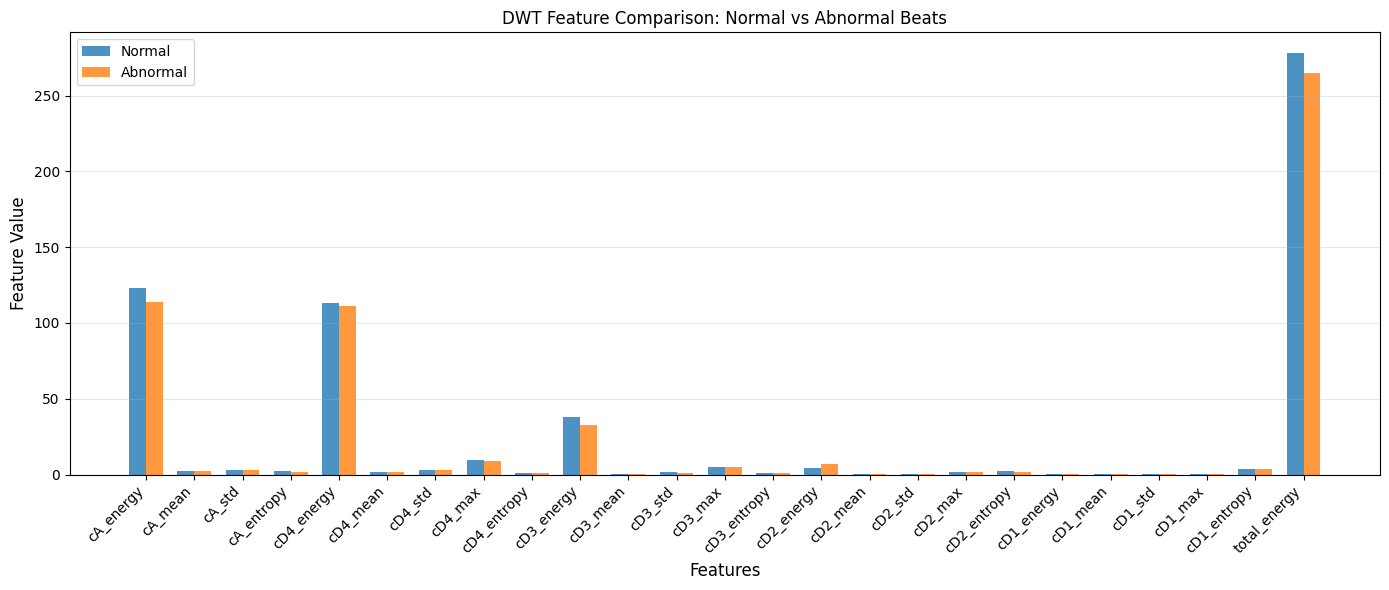


key feature differences:
feature              normal          abnormal        ratio     
cD3_energy           37.6327         32.7711         0.87      x
cD4_energy           112.9806        111.1975        0.98      x
cD3_max              5.0070          4.7636          0.95      x
cD4_max              9.3628          9.1904          0.98      x


In [16]:
beats = segments(ecg_processed, ann, fs, window_size = 0.3) 
print(f"beat types found: {list(beats.keys())}")

for beat_type, beat_list in beats.items(): 
    print(f"{beat_type}: {len(beat_list)}")

if('N' in beats): 
    n_feats = avg_fts(beats['N'][:10], wavelet='db4', level = lvl)

abnorm = None
for t in ['V', 'A', 'L', 'R', '/']: 
    if(t in beats and len(beats[t]) > 0): 
        abnorm = t 
        break 

if(abnorm): 
    print(f"\nabnormal features were identified (type '{abnorm}'). extracting features...") 
    abn_feats = avg_fts(beats[abnorm][:10], wavelet = 'db4', level = lvl)

    plot_feature_comparison(n_feats, abn_feats) 

    print("\nkey feature differences:")
    print(f"{'feature':<20} {'normal':<15} {'abnormal':<15} {'ratio':<10}")
    for key in ['cD3_energy', 'cD4_energy', 'cD3_max', 'cD4_max']:
        if key in n_feats and key in abn_feats:
            ratio = abn_feats[key] / n_feats[key]
            print(f"{key:<20} {n_feats[key]:<15.4f} {abn_feats[key]:<15.4f} {ratio:<10.2f}x")

else:
    print("\nno abnormal beats found in this segment.")


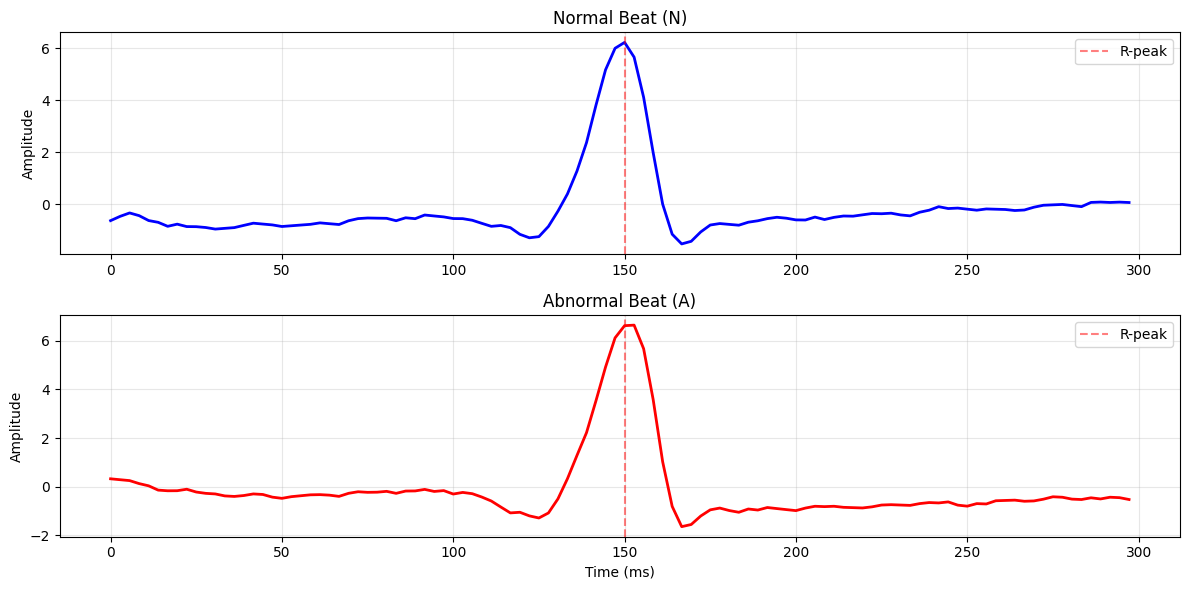

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
if 'N' in beats:
    
    # Plot normal beat
    time_beat = np.arange(len(beats['N'][0])) / fs * 1000  # in milliseconds
    axes[0].plot(time_beat, beats['N'][0], 'b-', linewidth=2)
    axes[0].set_title('Normal Beat (N)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    axes[0].axvline(x=len(beats['N'][0])/2 * 1000/fs, color='r', linestyle='--', alpha=0.5, label='R-peak')
    axes[0].legend()
    
    # Plot abnormal beat if available
if abnorm:
    axes[1].plot(time_beat, beats[abnorm][0], 'r-', linewidth=2)
    axes[1].set_title(f'Abnormal Beat ({abnorm})')
    axes[1].set_ylabel('Amplitude')
    axes[1].set_xlabel('Time (ms)')
    axes[1].grid(True, alpha=0.3)
    axes[1].axvline(x=len(beats[abnorm][0])/2 * 1000/fs, color='r', linestyle='--', alpha=0.5, label='R-peak')
    axes[1].legend()
    
plt.tight_layout()
plt.show()

# 6. Next Steps

- extract entropy feature from the DWT 
- perform statistical analysis between the average normal heartbeat features and abnormal heartbeat features. 
- knn to demonstrate applicability. 